In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys 
from torch.nn import functional as F
import configparser
import pandas as pd 

import numpy as np
import torch
import matplotlib.pyplot as plt

import matplotlib
# import evaluate
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from os.path import join as oj
sys.path.insert(0, "../src")
from unet import UNet
import my_data
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 
fig_path =config['PATHS']['figure_path'] 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import segmentation_models_pytorch as smp

In [33]:
net = smp.UnetPlusPlus(
    encoder_name="resnet34", encoder_weights='imagenet',  
    in_channels=1,                  
    classes=3,
).to(device=device)

In [34]:
net.load_state_dict(torch.load(oj(config['PATHS']['model_path'],  '9061125576.pt')))

<All keys matched successfully>

In [35]:

from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
x, y, num_classes, class_dict = my_data.load_layer_data( oj(config["DATASET"]["data_path"], 'lno') )
                        
# x = (x - x.min()) / (x.max() - x.min())
train_set = TensorDataset( *[ torch.Tensor(input) for input in my_data.make_dataset(x[:1], y[:1], img_size=128, offset=128, ) ] )

train_loader = DataLoader(train_set, batch_size=2, shuffle=False)


In [36]:
net.encoder

ResNetEncoder(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=T

In [28]:
out = net(torch.Tensor((x[:1, :1, :512, :512] - x.min())/ (x.max() - x.min())).to(device=device))

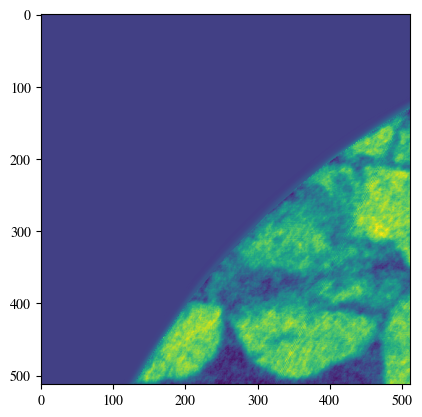

In [7]:
plt.imshow(x[0, 0, :512, :512])

In [17]:
import evaluate
from focal_loss.focal_loss import FocalLoss
# criterion = FocalLoss(gamma=0.7, ignore_index=255)
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)
net = net.train()
a = evaluate.emc(net, device, train_loader, (x.min(), x.max()), n_choose=-1, num_classes=3,criterion = criterion)

In [13]:
a.max()

2938660608.0

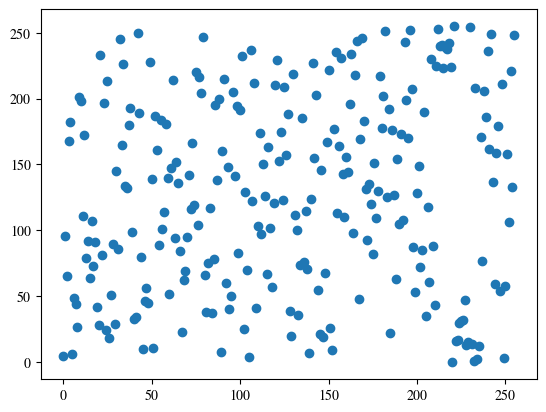

In [22]:
plt.scatter(np.arange(len(a)), a)

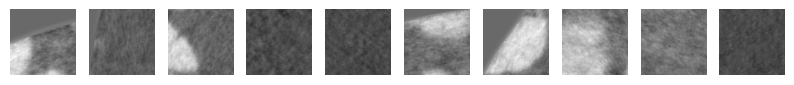

In [19]:
fig, ax = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    ax[i].imshow(train_loader.dataset[a[i]][0][0].numpy(), vmin=0, vmax=256, cmap='gray')
    ax[i].axis('off')


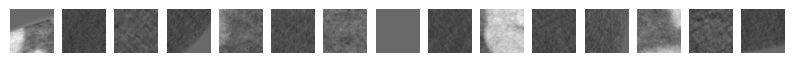

In [20]:
fig, ax = plt.subplots(1, 15, figsize=(10, 2))
for i in range(15):
    ax[i].imshow(train_loader.dataset[a[-i]][0][0].numpy(), vmin=0, vmax=256, cmap='gray')
    ax[i].axis('off')


In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    ax[i].imshow(train_loader.dataset[a[i]][0][0].numpy(), vmin=0, vmax=1, cmap='gray')
    ax[i].axis('off')

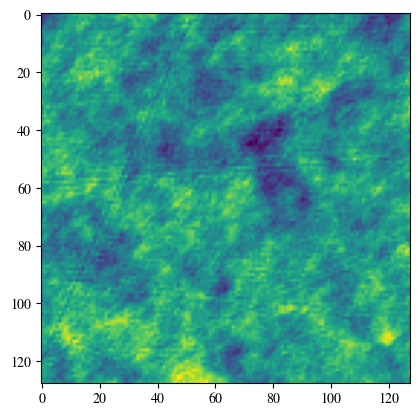

In [41]:
plt.imshow(train_loader.dataset[a[0]][0][0].numpy())

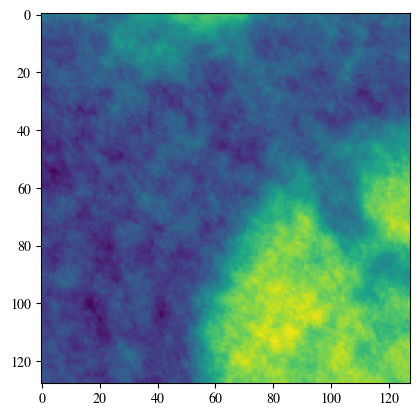

In [43]:
plt.imshow(train_loader.dataset[a[-4]][0][0].numpy())

In [8]:
a = []
for param in net.parameters():
    a.append(param)

In [14]:
net.

TypeError: 'UnetPlusPlus' object is not subscriptable

In [25]:
# need exp with no active learning
# need exp with prop increasingf
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results = pd.concat(results_list, axis=1).T.infer_objects()


results.reset_index(inplace=True)

results[['foldername',  'cost_function', 'add_ratio',  'final_dice_score', 
         'experiment_name']].groupby([ 'experiment_name', 'cost_function','add_ratio', 
         'foldername' ]).mean()


final_dice_score
experiment_name      cost_function add_ratio foldername                    
BActiveLearning      cut_off_cost  0.020     lno_halfHour             0.977
                                   0.040     lno_halfHour             0.981
                                   0.050     lno_halfHour             0.982
                                   0.080     lno_halfHour             0.983
                                   0.100     lno_halfHour             0.981
                     random_cost   0.020     lno_halfHour             0.975
                                   0.040     lno_halfHour             0.979
                                   0.050     lno_halfHour             0.978
                                   0.080     lno_halfHour             0.980
                                   0.100     lno_halfHour             0.981
BFullDatasetTraining random_cost   0.000     lno                      0.985
BNoActiveLearning    random_cost   0.000     lno_halfHour             0.966
LearningRate         random_cost   0.000     lno                      0.983
MyLittleNetwork      cut_off_cost  0.040     lno_halfHour             0.981

In [26]:
x, y, num_classes, class_dict = my_data.load_layer_data( oj(config["DATASET"]["data_path"], 'lno') )
data_min, data_max = np.min(x[:-1]), np.max(x[:-1])
x_test, y_test = x[-1:], y[-1:]
# x_test, y_test = my_data.stack_imgs(x_test, y_test)
x_test = (x_test - data_min) / (data_max - data_min)



In [34]:
results_filtered = results[results['experiment_name'] == 'BActiveLearning']
results_filtered = results_filtered[results_filtered['add_ratio'] == .04]

In [30]:
# results_filtered = results[results['experiment_name'] == 'BFullDatasetTraining']


In [31]:
len(results_filtered)

3

In [35]:
# male 
results_append = []

for index, row in results_filtered.iterrows():
    net = UNet(1, 3, ).to(device)
    net.load_state_dict(torch.load(oj(config['PATHS']['model_path'], row.file_name + '.pt',)))
    d = evaluate.final_evaluate(net, x_test, y_test, num_classes, device,separated_up=True, )
    results_append.append(d[1:].mean())

100%|██████████| 8/8 [00:52<00:00,  6.57s/it]


In [41]:
aq_dict = {}
for cost, results in zip(results_filtered['cost_function'], results_append):
    if cost in aq_dict:
        aq_dict[cost].append(results)
    else:
        aq_dict[cost] = [results,]

In [44]:
np.asarray(aq_dict['cut_off_cost']).mean()

0.9582101

In [46]:
np.asarray(aq_dict['cut_off_cost']).std()

0.009266638

In [45]:
np.asarray(aq_dict['random_cost']).mean()

0.9533183

In [47]:
np.asarray(aq_dict['random_cost']).std()

0.0062292945

In [36]:
results_filtered.cost_function

5     cut_off_cost
18    cut_off_cost
26     random_cost
59     random_cost
66     random_cost
73     random_cost
75     random_cost
82    cut_off_cost
86    cut_off_cost
88    cut_off_cost
Name: cost_function, dtype: object

In [ ]:
full_annot_dice = 0.959524

In [20]:
results.iloc[5]

index                                                               5
file_name                                                  0704730836
epochs                                                           2000
batch_size                                                        128
cost_function                                            cut_off_cost
add_ratio                                                       0.040
foldername                                               lno_halfHour
poolname                                                          lno
experiment_name                                       BActiveLearning
lr                                                              0.000
image_size                                                        128
add_size                                                            4
offset                                                             64
seed                                                                1
val                 

In [16]:
results.columns

Index(['index', 'file_name', 'epochs', 'batch_size', 'cost_function',
       'add_ratio', 'foldername', 'poolname', 'experiment_name', 'lr',
       'image_size', 'add_size', 'offset', 'seed', 'val', 'export_results',
       'add_step', 'progress_folder', 'final_patience', 'num_batches',
       'class_dict', 'data_min', 'data_max', 'val_scores', 'train_losses',
       'num_classes', 'final_dice_score', 'test_dice_score'],
      dtype='object')

100%|██████████| 8/8 [00:54<00:00,  6.80s/it]


In [ ]:
net = UNet(1, 3, ).to(device)
# my_models = [UNet(1, 3, bilinear = results_all.bilinear[0]).to(device) for i, _ in enumerate(results.file_name)] 

net.load_state_dict(torch.load(oj(config['PATHS']['model_path'], results.file_name[0] + '.pt',)))
net = net.to(device).eval()

In [10]:
d = evaluate.final_evaluate(net, x_test, y_test, num_classes, device,separated_up=True, )

100%|██████████| 8/8 [00:52<00:00,  6.62s/it]


In [12]:
d[1:].mean()

0.94116974

In [9]:
d

0.9580324292182922